Try to get Parke's bb code working with MM format.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [42]:
sed = Table.read('quicksaves/GJ674_basic.ecsv')

In [43]:
sed = sed[np.isnan(sed['FLUX'])==False]

In [8]:
star = 'gj_674'

In [22]:
"""def blackbody_fit(star):

    phx = io.read(db.findfiles('ir', 'phx', star))[0]

    # recursively identify relative maxima until there are fewer than N points
    N = 10000
    keep = np.arange(len(phx))
    while len(keep) > N:
        temp, = argrelmax(phx['flux'][keep])
        keep = keep[temp]

    Teff = rc.starprops['Teff_muscles'][star]
    efac = const.h * const.c / const.k_B / (Teff * u.K)
    efac  = efac.to(u.angstrom).value
    w = (phx['w0'] + phx['w1']) / 2.0
    w = w[keep]
    planck_shape = 1.0/w**5/(np.exp(efac/w) - 1)
    y = phx['flux'][keep]

    Sfy = np.sum(planck_shape * y)
    Sff = np.sum(planck_shape**2)

    norm = Sfy/Sff

    return lambda w: norm/w**5/(np.exp(efac/w) - 1)
"""
from scipy.signal import argrelmax

def blackbody_fit(star, phx, Teff):
    """Return a function that is a blackbody fit to the phoenix spectrum for the star. The fit is to the unnormalized
    phoenix spectrum, so the fit function values must be multiplied by the appropriate normalization factor to match
    the normalized spectrum."""

    
    # recursively identify relative maxima until there are fewer than N points
    N = 10000
    keep = np.arange(len(phx))
    while len(keep) > N:
        temp, = argrelmax(phx['FLUX'][keep])
        keep = keep[temp]

    efac = const.h * const.c / const.k_B / (Teff * u.K)
    efac  = efac.to(u.angstrom).value
    #w = (phx['w0'] + phx['w1']) / 2.0
    w = phx['WAVELENGTH']
    w = w[keep]
    planck_shape = 1.0/w**5/(np.exp(efac/w) - 1)
    y = phx['FLUX'][keep]

    Sfy = np.sum(planck_shape * y)
    Sff = np.sum(planck_shape**2)

    norm = Sfy/Sff

    return lambda w: norm/w**5/(np.exp(efac/w) - 1)


In [11]:
phx_path = glob.glob('../'+star+'/phoenix_repo/*')[0]
print(phx_path)
phx = Table.read(phx_path, format='ascii')

../gj_674/phoenix_repo/3400_4.5_0.0_0.0_phoenix_interpolated.txt


In [12]:
teff = 3400

In [23]:
blackbody_fit(star, phx, teff)

<function __main__.blackbody_fit.<locals>.<lambda>(w)>

In [24]:
def flux_integral(spectbl, wa=None, wb=None, normed=False):
    """Compute integral of flux from spectbl values. Result will be in erg/s/cm2."""
    if normed:
        if 'normflux' not in spectbl.colnames:
            spectbl = add_normflux(spectbl)

    assert wa is None or wa >= spectbl['w0'][0]
    assert wb is None or wb <= spectbl['w1'][-1]

    if hasattr(wa, '__iter__'):
        rng = np.asarray(wa)
        if rng.size == 2:
            wa, wb = rng
        elif rng.size > 2:
            results = [flux_integral(spectbl, _rng, normed=normed) for _rng in rng]
            fluxes, errs = zip(*results)
            return np.sum(fluxes), np.quadsum(errs)

    if wa is not None:
        spectbl = split_exact(spectbl, wa, 'red')
    if wb is not None:
        spectbl = split_exact(spectbl, wb, 'blue')

    dw = spectbl['w1'] - spectbl['w0']

    if normed:
        return np.sum(spectbl['normflux'] * dw), mnp.quadsum(spectbl['normerr'] * dw)
    else:
        return np.sum(spectbl['flux'] * dw), mnp.quadsum(spectbl['error'] * dw)t
    




def add_normflux(spectbl):
    """Add columns to the spectbl that are the bolometric-normalized flux and
    associated error."""
    if 'pan' in spectbl.meta['NAME']:
        normfac = bolo_integral(spectbl)
    else:
        normfac = bolo_integral(spectbl.meta['STAR'])
    spectbl['normflux'] = spectbl['flux']/normfac
    spectbl['normerr'] = spectbl['error']/normfac
    return spectbl


In [66]:
from scipy.integrate import quad

def bolo_integral(pan, star, phx, teff,normfac,uplim=np.inf):
    
    fit_unnormed = blackbody_fit(star, phx, teff)
    #normfac = pan[-1]['NORMFAC']
    #normfac = nf

    #Ibody = flux_integral(pan)[0]
    Ibody = np.trapz(pan['FLUX'], pan['WAVELENGTH'])
    print(Ibody)
    Itail = normfac*quad(fit_unnormed, pan['WAVELENGTH'][-1], uplim)[0]
    print(Itail)
    
    I = Ibody + Itail

    return I


In [67]:
bolo_integral(sed, star, phx, teff, nf)

2.1752947424938615e-08
4.210818081243574e-10


2.217402923306297e-08

In [59]:
nf = fits.getheader('../gj_674/test_files/components/hlsp_muscles_model_phx_gj674_na_v1_component-spec.fits',0)['NORMFAC']
print(nf)

2.92594915532614e-26


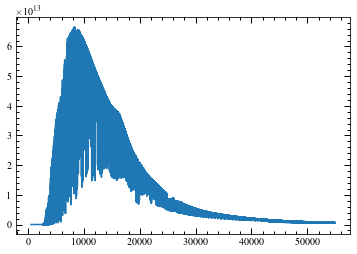

In [52]:
plt.plot(phx['WAVELENGTH'], phx['FLUX'])

In [53]:
sed['WAVELENGTH'][-1]

54999.75

In [55]:
fit_unnormed = blackbody_fit(star, phx, teff)
quad(fit_unnormed, sed['WAVELENGTH'][-1], np.inf)[0]*nf

4.210818081243574e-10

In [68]:
test_sed = fits.open('../../stuff/muscles_eg/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits')

In [70]:
data = test_sed[1].data

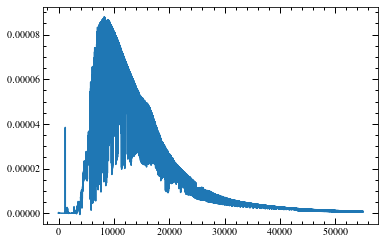

In [73]:
plt.plot(data['WAVELENGTH'], data['BOLOFLUX'])
#plt.plot(data['WAVELENGTH'], data['BOLOERR'])